In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

c:\Users\Eric\anaconda3\envs\ANLY501\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Wikipedia

In [2]:
df=pd.read_csv('./data/00-raw-data/wiki-crawl-results-arm.csv')  


In [3]:
corpus = df['text'].to_list()

In [4]:
text = '. '.join(corpus)

In [5]:
#INITIALIZE
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

stopwords = stopwords.words('english')
add=['000', 'doi' '19', '10', '1960s', '1970s', '1975', '1979', '978', 'isbn', '19th', '20th', 'would', 'also', 'access', 'year', 'without', 'well', 'new', 'york', 'one', 'century', 'since', 'first', 'day', 'time', 'united', 'formed', 'including', 'many', 'states', 'often', 'passed', 'must', 'part', 'made', 'based', 'week', 'organiation', 'form', 'state', 'american', 'world', 'nation', 'country', 'international']
for sp in add: 
    stopwords.append(sp)

In [6]:
tmp = ''
printable = set(string.printable)
for char in text:
    if char in printable:
        tmp = tmp + char
text = tmp

In [7]:
#BREAK INTO CHUNKS (SENTENCES OR OTHERWISE)
sentences=nltk.tokenize.sent_tokenize(text)  #SENTENCES

print("NUMBER OF SENTENCES FOUND:",len(sentences)); #print(sentences)

NUMBER OF SENTENCES FOUND: 6156


In [8]:
#CLEAN AND LEMMATIZE
keep='0123456789abcdefghijklmnopqrstuvwxy';

new_sentences=[]; vocabulary=[]
for sentence in sentences:
    new_sentence=''

    # REBUILD LEMMATIZED SENTENCE
    for word in sentence.split():
        
        #ONLY KEEP CHAR IN "keep"
        tmp2=''
        for char in word: 
            if(char in keep): 
                tmp2=tmp2+char
            else:
                tmp2=tmp2+' '
        word=tmp2

        #-----------------------
        # INSERT CODE TO LEMMATIZE THE WORDS
        #-----------------------
        new_word = lemmatizer.lemmatize(word)

        #REMOVE WHITE SPACES
        new_word=new_word.replace(' ', '')

        #BUILD NEW SENTENCE BACK UP
        if( new_word not in stopwords):
            if(new_sentence==''):
                new_sentence=new_word
            else:
                new_sentence=new_sentence+','+new_word
            if(new_word not in vocabulary): vocabulary.append(new_word)

    #SAVE (LIST OF LISTS)		
    new_sentences.append(new_sentence.split(","))
print("VOCAB LENGTH",len(vocabulary))

VOCAB LENGTH 12378


In [9]:
# INSERT CODE TO RE-FORMAT THE APRIORI OUTPUT INTO A PANDAS DATA-FRAME WITH COLUMNS "rhs","lhs","supp","conf","supp x conf","lift"
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

In [10]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

In [11]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=4000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='WikiCrawl Word Association Graph')
    plt.show()

# raise

In [12]:
# INSERT CODE TO TRAIN THE ARM MODEL USING THE "apriori" PACKAGE
print("Transactions:",pd.DataFrame(new_sentences))

results = list(apriori(new_sentences, min_support=0.02, min_lift = 1, min_confidence=0.02, min_length=1, max_length=2))
pd_results=reformat_results(results)

Transactions:              0           1            2            3            4    \
0     employment       right        woman      include          non   
1          right       woman          men        equal          pay   
2         leslie         wah        leung        chung         1917   
3            job      status        woman      changed    permanent   
4           even        lost          job         None         None   
...          ...         ...          ...          ...          ...   
6151     victory  observance  celebration       soviet        union   
6152         may       child     maldives  confederate     memorial   
6153         may          11     national   technology        india   
6154        iumo      taisha        japan     national  unification   
6155         end        june           15         army     slovenia   

                 5          6          7             8             9    ...  \
0     discriminatory      woman        job         equ

               rhs             lhs      supp      conf  supp x conf      lift
0       [abortion]           [law]  0.021118  0.286976     0.006060  2.693022
1            [law]      [abortion]  0.021118  0.198171     0.004185  2.693022
2          [equal]         [right]  0.021767  0.635071     0.013824  3.355792
3          [right]         [equal]  0.021767  0.115021     0.002504  3.355792
4       [equality]         [woman]  0.023067  0.642534     0.014821  1.588530
5          [woman]      [equality]  0.023067  0.057028     0.001315  1.588530
6         [family]         [woman]  0.020468  0.488372     0.009996  1.207397
7          [woman]        [family]  0.020468  0.050602     0.001036  1.207397
8         [female]         [woman]  0.021605  0.460208     0.009943  1.137766
9          [woman]        [female]  0.021605  0.053414     0.001154  1.137766
10      [feminist]         [woman]  0.022417  0.456954     0.010244  1.129722
11         [woman]      [feminist]  0.022417  0.055422     0.001

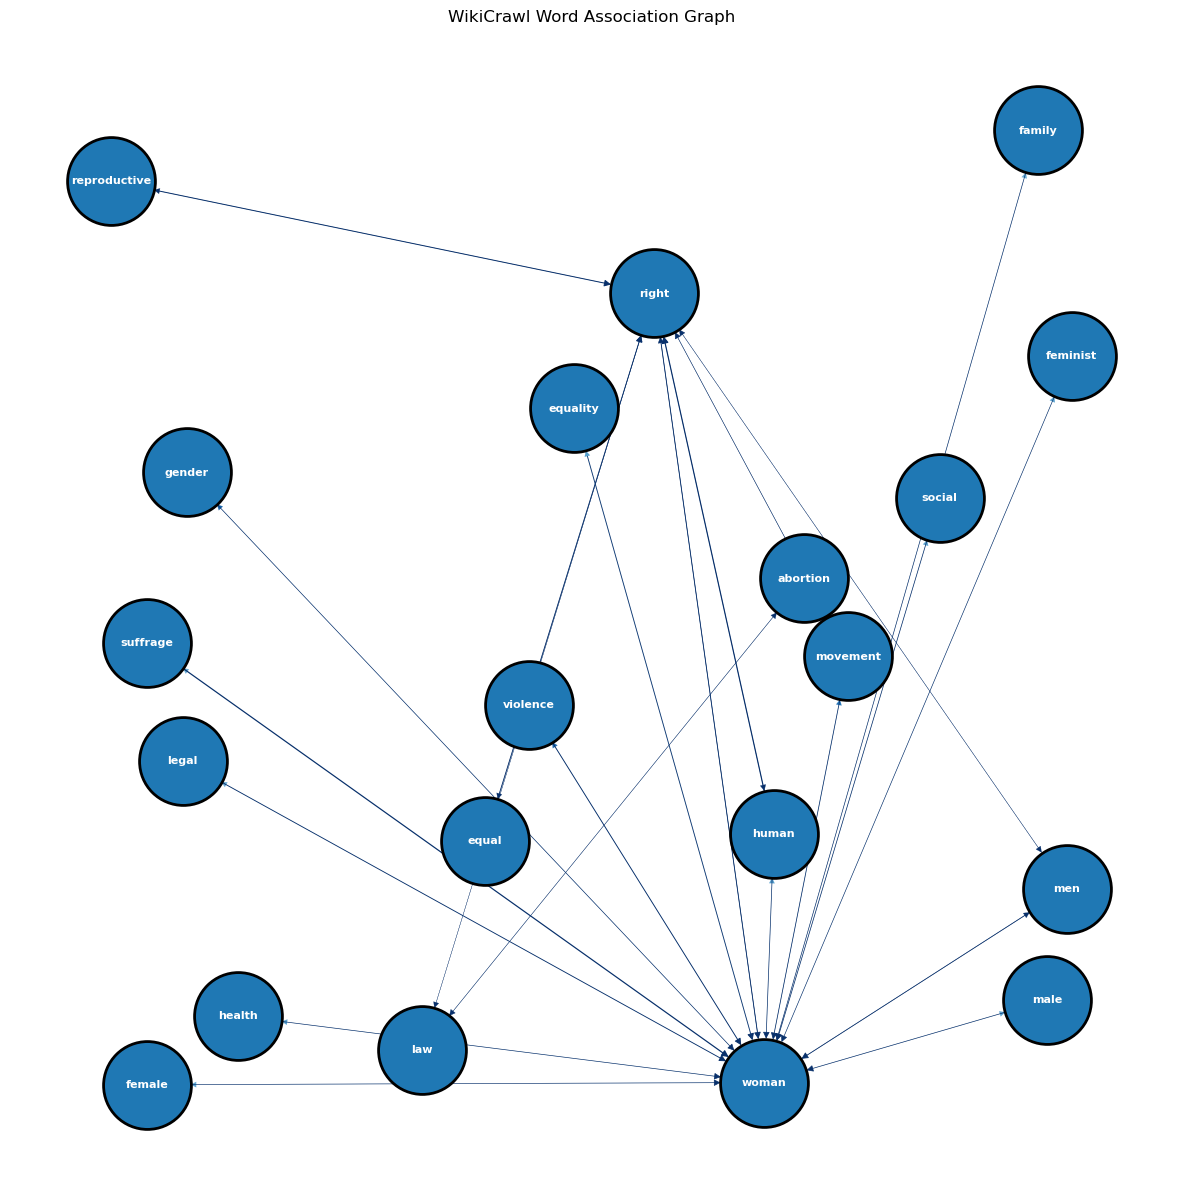

In [13]:
# INSERT CODE TO PLOT THE RESULTS AS A NETWORK-X OBJECT 
G=convert_to_network(pd_results)
plot_network(G)

In [15]:
# INSERT CODE TO TRAIN THE ARM MODEL USING THE "apriori" PACKAGE
print("Transactions:",pd.DataFrame(new_sentences))

supp_confs = [[0.002, 0.002],[0.02,0.02],[0.2,0.2]]

for s, c in supp_confs:
    results = list(apriori(new_sentences, min_support=s, min_lift = 1, min_confidence=c, min_length=1, max_length=3))
    pd_results=reformat_results(results)
    G=convert_to_network(pd_results)
    plot_network(G)

Transactions:              0           1            2            3            4    \
0     employment       right        woman      include          non   
1          right       woman          men        equal          pay   
2         leslie         wah        leung        chung         1917   
3            job      status        woman      changed    permanent   
4           even        lost          job         None         None   
...          ...         ...          ...          ...          ...   
6151     victory  observance  celebration       soviet        union   
6152         may       child     maldives  confederate     memorial   
6153         may          11     national   technology        india   
6154        iumo      taisha        japan     national  unification   
6155         end        june           15         army     slovenia   

                 5          6          7             8             9    ...  \
0     discriminatory      woman        job         equ

KeyboardInterrupt: 